In [1]:
model_name = 'lightgbm'
device = 'cpu'
min_samples_per_class = 5
n_classes = 3
n_frac = 0.005
n_trials_tpe = 10
plot_param_importances = False
timeout_tpe = 60
random_state = 42
n_jobs = -1

In [2]:
# Parameters
model_name = "xgboostrf"
device = "cpu"
min_samples_per_class = 5
n_classes = 8
n_frac = 0.1
n_trials_tpe = 1000
plot_param_importances = False
timeout_tpe = 3600
random_state = 42
n_jobs = -1


In [3]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# UTILS

In [4]:
def stratified_sample_df(df, stratify_col, frac, min_samples_per_class, random_state):
    grouped = df.groupby(stratify_col)
    sample = grouped.apply(
        lambda x: x.sample(
            n=max(min_samples_per_class, int(len(x) * frac)), 
            replace=len(x) < max(min_samples_per_class, int(len(x) * frac)),
            random_state=random_state
        )
    ).reset_index(drop=True)
    return sample

In [5]:
def build_classifier(extra_kwargs={}):
    clf = None
    if model_name in ['lgbm', 'lightgbm']:
        import lightgbm as lgb
        kwargs = {
            'device_type': device,
            'n_jobs': n_jobs,
            'objective': 'binary' if n_classes == 2 else 'multiclass',
            'random_state': random_state,
            'verbose': 1,
            **extra_kwargs
        }
        if n_classes > 2:
            kwargs['num_class'] = n_classes
        clf = lgb.LGBMClassifier(**kwargs)
    elif model_name in ['xgb', 'xgboost']:
        from xgboost import XGBClassifier
        kwargs = {
            'device': device,
            'eval_metric': 'logloss' if n_classes == 2 else 'mlogloss',
            'n_jobs': n_jobs,
            'random_state': random_state,
            'tree_method': 'hist',
            **extra_kwargs
        }
        clf = XGBClassifier(**kwargs)
    elif model_name in ['xgbrf', 'xgboostrf']:
        from xgboost import XGBRFClassifier
        kwargs = {
            'device': device,
            'eval_metric': 'logloss' if n_classes == 2 else 'mlogloss',
            'n_jobs': n_jobs,
            'random_state': random_state,
            'tree_method': 'hist',
            **extra_kwargs
        }
        clf = XGBRFClassifier(**kwargs)
    return clf

In [6]:
from collections import OrderedDict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def process_metrics(y_test, y_pred):
    
    accuracy = accuracy_score(y_test, y_pred)
    
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    results = OrderedDict({
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Precision (Micro)': precision_micro,
        'Precision (Weighted)': precision_weighted,
        'Recall (Macro)': recall_macro,
        'Recall (Micro)': recall_micro,
        'Recall (Weighted)': recall_weighted,
        'F1 (Macro)': f1_macro,
        'F1 (Micro)': f1_micro,
        'F1 (Weighted)': f1_weighted
    })

    pprint(results, indent=4)

In [7]:
from sklearn.metrics import classification_report

def process_classification_report(y_test, y_pred):
    try:
        cr = classification_report(y_test, y_pred, digits=6, target_names=labels)
        print(cr)
    except Exception as e:
        print('Cloud not build/show classification report. Reason:', e)

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def process_confusion_matrix(y_test, y_pred):
    try:
        y_test_decoded = [index_to_label[label] for label in y_test]
        y_pred_decoded = [index_to_label[label] for label in y_pred]
        cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)
        cm = np.round(cm / 1000, 1)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(values_format='g')
    except Exception as e:
        print('Cloud not build/show confusion matrix. Reason:', e)

In [9]:
import numpy as np

def value_counts_to_dict(array):
    unique, counts = np.unique(array, return_counts=True)
    value_counts_dict = dict(zip(unique, counts))
    return value_counts_dict

# STEP 1: DATA PREP

In [10]:
# %load_ext cudf.pandas
import numpy as np
import pandas as pd
from pprint import pprint

if n_classes == 3: # dummy dataset
    df_sample = pd.read_parquet('input/dummy.parquet')
else:
    df_sample = pd.read_parquet(f'input/CICIoT2023_{n_classes}.parquet')

df_sample['label'], unique_values = df_sample['label'].factorize()

label_to_index = {value: i for i, value in enumerate(unique_values)}
index_to_label = {v: k for k, v in label_to_index.items()}
labels = list(label_to_index.keys())
pprint(label_to_index, indent=4)

{   'Benign': 3,
    'BruteForce': 7,
    'DDoS': 0,
    'DoS': 1,
    'Mirai': 2,
    'Recon': 5,
    'Spoofing': 4,
    'WebBased': 6}


In [11]:
# not stratified df sampling (just to check)
df_sample['label'].sample(frac=n_frac, random_state=random_state).value_counts()

label
0    3397209
1     809281
2     264004
3     109844
4      48837
5      35677
6       2539
7       1267
Name: count, dtype: int64

In [12]:
# stratified df sampling
df_sample = stratified_sample_df(df_sample, 'label', n_frac, min_samples_per_class, random_state)

/tmp/ipykernel_3440246/2006267505.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = grouped.apply(


In [13]:
df_sample['label'].value_counts()

label
0    3398456
1     809073
2     263412
3     109819
4      48650
5      35456
6       2482
7       1306
Name: count, dtype: int64

In [14]:
X_sample = df_sample.drop('label', axis=1)

print(type(X_sample))
print(X_sample.shape)
print(X_sample.dtypes)

<class 'pandas.core.frame.DataFrame'>
(4668654, 46)
flow_duration      float32
Header_Length      float32
Protocol Type      float32
Duration           float32
Rate               float32
Srate              float32
Drate              float32
fin_flag_number    float32
syn_flag_number    float32
rst_flag_number    float32
psh_flag_number    float32
ack_flag_number    float32
ece_flag_number    float32
cwr_flag_number    float32
ack_count          float32
syn_count          float32
fin_count          float32
urg_count          float32
rst_count          float32
HTTP               float32
HTTPS              float32
DNS                float32
Telnet             float32
SMTP               float32
SSH                float32
IRC                float32
TCP                float32
UDP                float32
DHCP               float32
ARP                float32
ICMP               float32
IPv                float32
LLC                float32
Tot sum            float32
Min                float32
Max

In [15]:
y_sample = df_sample['label']

print(type(y_sample))
print(y_sample.shape)
print(y_sample.dtype)
print(y_sample.unique())
print(y_sample.nunique())
y_sample.value_counts()

<class 'pandas.core.series.Series'>
(4668654,)
int64
[0 1 2 3 4 5 6 7]
8


label
0    3398456
1     809073
2     263412
3     109819
4      48650
5      35456
6       2482
7       1306
Name: count, dtype: int64

In [16]:
from sklearn.model_selection import train_test_split

# Split into 80% training+validation and 20% test
X_sample_train_val, X_sample_test, y_sample_train_val, y_sample_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=random_state, stratify=y_sample
)

# Split the 80% training+validation set into 75% training and 25% validation
X_sample_train, X_sample_val, y_sample_train, y_sample_val = train_test_split(
    X_sample_train_val, y_sample_train_val, test_size=0.25, random_state=random_state, stratify=y_sample_train_val
)

# Verify the sizes of the splits
print(f'Training   : {len(X_sample_train)}\t({(100.0 * len(X_sample_train) / len(X_sample)):.2f}) %\t{sorted(y_sample_train.unique())}')
print(f'Validation : {len(X_sample_val)}\t({(100.0 * len(X_sample_val) / len(X_sample)):.2f}) %\t{sorted(y_sample_val.unique())}')
print(f'Test       : {len(X_sample_test)}\t({(100.0 * len(X_sample_test) / len(X_sample)):.2f}) %\t{sorted(y_sample_test.unique())}')

Training   : 2801192	(60.00) %	[0, 1, 2, 3, 4, 5, 6, 7]
Validation : 933731	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7]
Test       : 933731	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7]


In [17]:
assert sorted(y_sample_train.unique()) == sorted(y_sample_val.unique())
assert sorted(y_sample_train.unique()) == sorted(y_sample_test.unique())
assert sorted(y_sample_val.unique()) == sorted(y_sample_test.unique())

# STEP 2: PREPROCESSING & FEATURE SELECTION

### Preprocessing Methods

In [18]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer, RobustScaler, StandardScaler

class DummyPreprocessor:
    def fit(self, _X, _y=None):
        return self
    def transform(self, _X):
        return _X

def make_preprocessor(pp_method):
    preprocessor = None
    if pp_method == 'none':
        preprocessor = DummyPreprocessor()
    if pp_method == 'maxabs':
        preprocessor = MaxAbsScaler()
    elif pp_method == 'minmax':
        preprocessor = MinMaxScaler()
    elif pp_method == 'norm':
        preprocessor = Normalizer()
    elif pp_method == 'robust':
        preprocessor = RobustScaler()
    elif pp_method == 'standard':
        preprocessor = StandardScaler()
    return preprocessor

### Feature Selection Methods

In [19]:
from shaphypetune import BoostSearch, BoostBoruta, BoostRFE, BoostRFA

class DummyFeatureSelector:
    def fit(self, _X, _y, _eval_set=None):
        self.support_ = np.ones(_X.shape[1], dtype=bool)
        return self
    def transform(self, _X):
        return _X[:, self.support_]

def make_feature_selector(fs_method, fs_metric):
    feature_selector = None
    if fs_method == 'none':
        feature_selector = DummyFeatureSelector()
    elif fs_method == 'boruta':
        feature_selector = BoostBoruta(build_classifier(), importance_type=fs_metric, perc=100, sampling_seed=random_state)
    elif fs_method == 'rfa':
        feature_selector = BoostRFA(build_classifier(), importance_type=fs_metric, min_features_to_select=1, sampling_seed=random_state, step=1)
    elif fs_method == 'rfe':
        feature_selector = BoostRFE(build_classifier(), importance_type=fs_metric, min_features_to_select=1, sampling_seed=random_state, step=1)
    return feature_selector

### HPO

In [20]:
%%time

import optuna

from optuna.samplers import GridSampler

def objective(trial):

    try:
        # preprocessing hyperparameters
        pp_method = trial.suggest_categorical('pp_method', ['none', 'maxabs', 'minmax', 'norm', 'robust', 'standard'])

        # feature selection hyperparameters
        fs_method = trial.suggest_categorical('fs_method', ['none', 'boruta', 'rfa', 'rfe'])
        fs_metric = trial.suggest_categorical('fs_metric', ['feature_importances', 'shap_importances'])
        
        # pipeline - preprocessing
        preprocessor = make_preprocessor(pp_method)
        preprocessor.fit(X_sample_train)
        X_sample_train_prep = pd.DataFrame(preprocessor.transform(X_sample_train.copy()), columns=X_sample_train.columns)
        X_sample_val_prep = pd.DataFrame(preprocessor.transform(X_sample_val.copy()), columns=X_sample_val.columns)
        X_sample_test_prep = pd.DataFrame(preprocessor.transform(X_sample_test.copy()), columns=X_sample_test.columns)
    
        # pipeline - feature selection
        feature_selector = make_feature_selector(fs_method, fs_metric)
        feature_selector.fit(X_sample_train_prep, y_sample_train, eval_set=[(X_sample_val_prep, y_sample_val)])
        selected_features = X_sample_train_prep.columns[feature_selector.support_]
        trial.set_user_attr('selected_features', selected_features)
        
        # pipeline - classifier fit/predict
        model = build_classifier()
        model.fit(X_sample_train_prep[selected_features], y_sample_train)
        y_sample_pred = model.predict(X_sample_test_prep[selected_features])
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)
        
    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a Grid sampler
search_space = {
    'pp_method': ['none', 'maxabs', 'minmax', 'norm', 'robust', 'standard'],
    'fs_method': ['boruta', 'rfa', 'rfe'],
    'fs_metric': ['feature_importances', 'shap_importances']
}
sampler = GridSampler(search_space)
n_trials_grid = np.prod([len(v) for v in search_space.values()])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_grid)

[I 2024-07-21 10:55:21,989] A new study created in memory with name: no-name-71536e9a-272d-49fb-9682-55d36eea9e35


[I 2024-07-21 11:23:07,619] Trial 0 pruned. 


index 7 is out of bounds for axis 0 with size 6


[I 2024-07-21 12:33:25,335] Trial 1 finished with value: 0.7019147100700656 and parameters: {'pp_method': 'maxabs', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 1 with value: 0.7019147100700656.


[I 2024-07-21 13:05:16,744] Trial 2 pruned. 


index 6 is out of bounds for axis 0 with size 6


[I 2024-07-21 13:40:37,706] Trial 3 finished with value: 0.705101808763655 and parameters: {'pp_method': 'robust', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 3 with value: 0.705101808763655.


[I 2024-07-21 14:08:32,298] Trial 4 pruned. 


index 7 is out of bounds for axis 0 with size 6


[I 2024-07-21 14:40:14,368] Trial 5 pruned. 


index 6 is out of bounds for axis 0 with size 6


[I 2024-07-21 15:15:22,425] Trial 6 finished with value: 0.7017382268745986 and parameters: {'pp_method': 'maxabs', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 3 with value: 0.705101808763655.


[I 2024-07-21 15:46:55,514] Trial 7 finished with value: 0.7011481999771607 and parameters: {'pp_method': 'minmax', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 3 with value: 0.705101808763655.


[I 2024-07-21 16:55:18,515] Trial 8 finished with value: 0.7019147100700656 and parameters: {'pp_method': 'none', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 3 with value: 0.705101808763655.


[I 2024-07-21 17:30:39,213] Trial 9 finished with value: 0.7051079211252311 and parameters: {'pp_method': 'standard', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 9 with value: 0.7051079211252311.


[I 2024-07-21 18:05:48,464] Trial 10 finished with value: 0.7017382268745986 and parameters: {'pp_method': 'minmax', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 9 with value: 0.7051079211252311.


[I 2024-07-21 18:11:02,655] Trial 11 pruned. 


shape mismatch: value array of shape (46,8) could not be broadcast to indexing result of shape (46,)


[I 2024-07-21 18:37:55,860] Trial 12 finished with value: 0.7052001336266974 and parameters: {'pp_method': 'robust', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 12 with value: 0.7052001336266974.


[I 2024-07-21 19:04:06,835] Trial 13 finished with value: 0.7688043625612755 and parameters: {'pp_method': 'norm', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 13 with value: 0.7688043625612755.


[I 2024-07-21 19:37:55,040] Trial 14 pruned. 


index 6 is out of bounds for axis 0 with size 6


[I 2024-07-21 20:43:41,508] Trial 15 finished with value: 0.7682382690327503 and parameters: {'pp_method': 'norm', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 13 with value: 0.7688043625612755.


[I 2024-07-21 20:48:58,592] Trial 16 pruned. 


shape mismatch: value array of shape (46,8) could not be broadcast to indexing result of shape (46,)


[I 2024-07-21 21:20:53,928] Trial 17 pruned. 


index 6 is out of bounds for axis 0 with size 6


[I 2024-07-21 22:29:12,567] Trial 18 finished with value: 0.7053195119597631 and parameters: {'pp_method': 'standard', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 13 with value: 0.7688043625612755.


[I 2024-07-21 23:02:56,876] Trial 19 finished with value: 0.7707712105600434 and parameters: {'pp_method': 'norm', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 19 with value: 0.7707712105600434.


[I 2024-07-21 23:31:05,147] Trial 20 pruned. 


index 7 is out of bounds for axis 0 with size 6


[I 2024-07-21 23:53:55,764] Trial 21 finished with value: 0.7055053235762972 and parameters: {'pp_method': 'standard', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 19 with value: 0.7707712105600434.


[I 2024-07-21 23:59:07,775] Trial 22 pruned. 


shape mismatch: value array of shape (46,8) could not be broadcast to indexing result of shape (46,)


[I 2024-07-22 01:07:10,008] Trial 23 finished with value: 0.7019147100700656 and parameters: {'pp_method': 'minmax', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 19 with value: 0.7707712105600434.


[I 2024-07-22 01:39:00,947] Trial 24 pruned. 


index 6 is out of bounds for axis 0 with size 6


[I 2024-07-22 02:07:14,464] Trial 25 pruned. 


index 7 is out of bounds for axis 0 with size 6


[I 2024-07-22 02:38:54,560] Trial 26 finished with value: 0.7011481999771607 and parameters: {'pp_method': 'maxabs', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 19 with value: 0.7707712105600434.


[I 2024-07-22 03:10:38,485] Trial 27 pruned. 


index 6 is out of bounds for axis 0 with size 6


[I 2024-07-22 03:38:49,682] Trial 28 pruned. 


index 7 is out of bounds for axis 0 with size 6


[I 2024-07-22 03:44:06,711] Trial 29 pruned. 


shape mismatch: value array of shape (46,8) could not be broadcast to indexing result of shape (46,)


[I 2024-07-22 04:15:40,152] Trial 30 finished with value: 0.7011481999771607 and parameters: {'pp_method': 'none', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 19 with value: 0.7707712105600434.


[I 2024-07-22 05:24:26,055] Trial 31 finished with value: 0.7055405912919015 and parameters: {'pp_method': 'robust', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 19 with value: 0.7707712105600434.


[I 2024-07-22 05:54:30,681] Trial 32 pruned. 


index 7 is out of bounds for axis 0 with size 6


[I 2024-07-22 06:30:01,175] Trial 33 finished with value: 0.7017382268745986 and parameters: {'pp_method': 'none', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 19 with value: 0.7707712105600434.


[I 2024-07-22 06:35:16,342] Trial 34 pruned. 


shape mismatch: value array of shape (46,8) could not be broadcast to indexing result of shape (46,)


[I 2024-07-22 06:40:48,182] Trial 35 pruned. 


shape mismatch: value array of shape (46,8) could not be broadcast to indexing result of shape (46,)
CPU times: user 25d 3h 51min 11s, sys: 31min 46s, total: 25d 4h 22min 57s
Wall time: 19h 45min 26s


In [21]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0       NaN 2024-07-21 10:55:21.989816 2024-07-21 11:23:07.619015   
1        1  0.701915 2024-07-21 11:23:07.619753 2024-07-21 12:33:25.335647   
2        2       NaN 2024-07-21 12:33:25.336499 2024-07-21 13:05:16.744342   
3        3  0.705102 2024-07-21 13:05:16.745046 2024-07-21 13:40:37.706227   
4        4       NaN 2024-07-21 13:40:37.707081 2024-07-21 14:08:32.298535   
5        5       NaN 2024-07-21 14:08:32.299450 2024-07-21 14:40:14.368363   
6        6  0.701738 2024-07-21 14:40:14.369279 2024-07-21 15:15:22.425584   
7        7  0.701148 2024-07-21 15:15:22.426665 2024-07-21 15:46:55.514643   
8        8  0.701915 2024-07-21 15:46:55.515660 2024-07-21 16:55:18.514909   
9        9  0.705108 2024-07-21 16:55:18.515708 2024-07-21 17:30:39.213293   
10      10  0.701738 2024-07-21 17:30:39.214335 2024-07-21 18:05:48.463998   
11      11       NaN 2024-07-21 18:05:48.464780 2024-07-21 18:11:02.655292   
12      12  0.705200 2024-07-21 18:11:02.655928 2024-07-21 18:37:55.860005   
13      13  0.768804 2024-07-21 18:37:55.861053 2024-07-21 19:04:06.835642   
14      14       NaN 2024-07-21 19:04:06.836299 2024-07-21 19:37:55.039932   
15      15  0.768238 2024-07-21 19:37:55.040562 2024-07-21 20:43:41.508692   
16      16       NaN 2024-07-21 20:43:41.509542 2024-07-21 20:48:58.591935   
17      17       NaN 2024-07-21 20:48:58.592581 2024-07-21 21:20:53.928889   
18      18  0.705320 2024-07-21 21:20:53.929575 2024-07-21 22:29:12.567665   
19      19  0.770771 2024-07-21 22:29:12.568708 2024-07-21 23:02:56.876699   
20      20       NaN 2024-07-21 23:02:56.877567 2024-07-21 23:31:05.146966   
21      21  0.705505 2024-07-21 23:31:05.147501 2024-07-21 23:53:55.764004   
22      22       NaN 2024-07-21 23:53:55.764878 2024-07-21 23:59:07.775056   
23      23  0.701915 2024-07-21 23:59:07.775825 2024-07-22 01:07:10.008059   
24      24       NaN 2024-07-22 01:07:10.009085 2024-07-22 01:39:00.947363   
25      25       NaN 2024-07-22 01:39:00.948244 2024-07-22 02:07:14.463949   
26      26  0.701148 2024-07-22 02:07:14.464814 2024-07-22 02:38:54.560159   
27      27       NaN 2024-07-22 02:38:54.561214 2024-07-22 03:10:38.484933   
28      28       NaN 2024-07-22 03:10:38.485711 2024-07-22 03:38:49.682904   
29      29       NaN 2024-07-22 03:38:49.683619 2024-07-22 03:44:06.711325   
30      30  0.701148 2024-07-22 03:44:06.712161 2024-07-22 04:15:40.152381   
31      31  0.705541 2024-07-22 04:15:40.153404 2024-07-22 05:24:26.055356   
32      32       NaN 2024-07-22 05:24:26.056381 2024-07-22 05:54:30.681152   
33      33  0.701738 2024-07-22 05:54:30.682044 2024-07-22 06:30:01.175587   
34      34       NaN 2024-07-22 06:30:01.176249 2024-07-22 06:35:16.342158   
35      35       NaN 2024-07-22 06:35:16.342936 2024-07-22 06:40:48.181958   

                 duration params_fs_method     params_fs_metric  \
0  0 days 00:27:45.629199              rfe     shap_importances   
1  0 days 01:10:17.715894              rfa  feature_importances   
2  0 days 00:31:51.407843              rfa     shap_importances   
3  0 days 00:35:20.961181              rfe  feature_importances   
4  0 days 00:27:54.591454              rfe     shap_importances   
5  0 days 00:31:42.068913              rfa     shap_importances   
6  0 days 00:35:08.056305              rfe  feature_importances   
7  0 days 00:31:33.087978           boruta  feature_importances   
8  0 days 01:08:22.999249              rfa  feature_importances   
9  0 days 00:35:20.697585              rfe  feature_importances   
10 0 days 00:35:09.249663              rfe  feature_importances   
11 0 days 00:05:14.190512           boruta     shap_importances   
12 0 days 00:26:53.204077           boruta  feature_importances   
13 0 days 00:26:10.974589           boruta  feature_importances   
14 0 days 00:33:48.203633              rfa     shap_importances   
15 0 days 01:05:46.468130              rfa  f

In [22]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [23]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [24]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [25]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

[W 2024-07-22 06:40:49,618] Param fs_metric unique value length is less than 2.


[W 2024-07-22 06:40:49,619] Param fs_metric unique value length is less than 2.


[W 2024-07-22 06:40:49,619] Param fs_metric unique value length is less than 2.


[W 2024-07-22 06:40:49,619] Param fs_metric unique value length is less than 2.


In [26]:
best_preprocessor = make_preprocessor(study.best_trial.params['pp_method'])
best_preprocessor.fit(X_sample_train)
X_sample_train = pd.DataFrame(best_preprocessor.transform(X_sample_train.copy()), columns=X_sample_train.columns)
X_sample_val = pd.DataFrame(best_preprocessor.transform(X_sample_val.copy()), columns=X_sample_val.columns)
X_sample_test = pd.DataFrame(best_preprocessor.transform(X_sample_test.copy()), columns=X_sample_test.columns)

best_selected_features = study.best_trial.user_attrs['selected_features']
X_sample_train = X_sample_train[best_selected_features]
X_sample_val = X_sample_val[best_selected_features]
X_sample_test = X_sample_test[best_selected_features]

# STEP 3: DATA BALANCING

### Oversampling

In [27]:
# from cuml.neighbors import KNeighborsClassifier
# from cuml.neighbors import NearestNeighbors
from imblearn.over_sampling import *

def build_oversampling_strategy(value_counts, threshold):
    n_occurences = sum([n for n in value_counts.values()])
    perfectly_balanced_occurences = int(n_occurences / len(value_counts.keys()))
    if threshold == "auto":
        n_generate = {
            class_: perfectly_balanced_occurences - occ
                    if occ < perfectly_balanced_occurences else 0
                    for class_, occ in value_counts.items()
        }
    else:
        n_generate = {
            class_: int(min(occ * threshold, perfectly_balanced_occurences - occ))
            if occ < perfectly_balanced_occurences else 0
            for class_, occ in value_counts.items()
        }
    return n_generate

def patch_oversampling_strategy(value_counts, n_generate):
    return {k : (value_counts[k] + n_generate[k]) for k in value_counts.keys()}

def make_over_sampler(over_strategy):
    over_sampler = RandomOverSampler(
        random_state=random_state, sampling_strategy=over_strategy)
    return over_sampler

### Undersampling

In [28]:
# from cuml.neighbors import KNeighborsClassifier
# from cuml.neighbors import NearestNeighbors
from imblearn.under_sampling import *

def build_undersampling_strategy(value_counts, threshold):
    n_occurences = sum([n for n in value_counts.values()])
    perfectly_balanced_occurences = int(n_occurences / len(value_counts.keys()))
    if threshold == "auto":
        n_remove = {
            class_: occ - perfectly_balanced_occurences
                    if occ > perfectly_balanced_occurences else 0
                    for class_, occ in value_counts.items()
        }
    else:
        n_remove = {
            class_: int(min(occ * threshold, occ - perfectly_balanced_occurences))
            if occ > perfectly_balanced_occurences else 0
            for class_, occ in value_counts.items()
        }
    return n_remove

def patch_undersampling_strategy(value_counts, n_remove):
    return {k : (value_counts[k] - n_remove[k]) for k in value_counts.keys()}

def make_under_sampler(under_strategy):
    under_sampler = RandomUnderSampler(
        random_state=random_state, sampling_strategy=under_strategy)
    return under_sampler

### Combination

In [29]:
def fit_resample(_X_train, _y_train, over_thresh, under_thresh):

    _X_names = _X_train.columns.tolist()
    _y_name = _y_train.name
    
    _X_train_copy = _X_train.copy()
    _y_train_copy = _y_train.copy()

    if over_thresh:
        value_counts = value_counts_to_dict(_y_train_copy)
        n_generate = build_oversampling_strategy(value_counts, over_thresh)
        over_strategy = patch_oversampling_strategy(value_counts, n_generate)
        over_sampler = make_over_sampler(over_strategy)
        _X_train_copy, _y_train_copy = over_sampler.fit_resample(_X_train_copy, _y_train_copy)

    if under_thresh:
        value_counts = value_counts_to_dict(_y_train_copy)
        n_remove = build_undersampling_strategy(value_counts, under_thresh)
        under_strategy = patch_undersampling_strategy(value_counts, n_remove)
        under_sampler = make_under_sampler(under_strategy)
        _X_train_copy, _y_train_copy = under_sampler.fit_resample(_X_train_copy, _y_train_copy)

    return pd.DataFrame(_X_train_copy, columns=_X_names), pd.Series(_y_train_copy, name=_y_name)

### HPO

In [30]:
from itertools import chain

over_threshold_choices = list(chain(*[np.linspace(0, 4, num=17).round(2), ['auto']]))
under_threshold_choices = list(chain(*[np.linspace(0, 0.95, num=20).round(2), ['auto']]))

In [31]:
%%time
def objective(trial):

    try:
        # data balancing hyperparameters
        over_threshold = trial.suggest_categorical('over_threshold', over_threshold_choices)
        under_threshold = trial.suggest_categorical('under_threshold', under_threshold_choices)
    
        # pipeline - data balancing
        X_sample_train_bal, y_sample_train_bal = fit_resample(
            X_sample_train, y_sample_train, over_threshold, under_threshold
        )
        
        # pipeline - classifier fit/predict
        model = build_classifier()
        model.fit(X_sample_train_bal, y_sample_train_bal)
        y_sample_pred = model.predict(X_sample_test)
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)

    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a Grid sampler
search_space = {
    'over_threshold': over_threshold_choices,
    'under_threshold': under_threshold_choices
}
sampler = GridSampler(search_space)
n_trials_grid = np.prod([len(v) for v in search_space.values()])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_grid)

[I 2024-07-22 06:40:51,145] A new study created in memory with name: no-name-755b1fe4-4c7c-47c4-8e3e-7ff869418bd4


[I 2024-07-22 06:41:26,659] Trial 0 finished with value: 0.8195468656847615 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.65}. Best is trial 0 with value: 0.8195468656847615.


[I 2024-07-22 06:41:53,837] Trial 1 finished with value: 0.8027751485049 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.95}. Best is trial 0 with value: 0.8195468656847615.


[I 2024-07-22 06:42:36,006] Trial 2 finished with value: 0.8258578067393194 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.3}. Best is trial 2 with value: 0.8258578067393194.


[I 2024-07-22 06:43:20,638] Trial 3 finished with value: 0.8240397249917385 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.3}. Best is trial 2 with value: 0.8258578067393194.


[I 2024-07-22 06:43:50,597] Trial 4 finished with value: 0.7815205818538769 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.6}. Best is trial 2 with value: 0.8258578067393194.


[I 2024-07-22 06:44:27,526] Trial 5 finished with value: 0.7964622308969355 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.2}. Best is trial 2 with value: 0.8258578067393194.


[I 2024-07-22 06:45:04,465] Trial 6 finished with value: 0.822664677941569 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.6}. Best is trial 2 with value: 0.8258578067393194.


[I 2024-07-22 06:45:48,430] Trial 7 finished with value: 0.8367072645099004 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.15}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 06:46:21,743] Trial 8 finished with value: 0.8133338034041125 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.35}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 06:46:59,793] Trial 9 finished with value: 0.8110428978453798 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.7}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 06:47:42,497] Trial 10 finished with value: 0.8178926765015352 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.45}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 06:48:29,113] Trial 11 finished with value: 0.8037078465030671 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.0}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 06:49:21,099] Trial 12 finished with value: 0.7243441914186911 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.65}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 06:50:19,161] Trial 13 finished with value: 0.7291093722288188 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.25}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 06:51:00,062] Trial 14 finished with value: 0.8074612591223067 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.4}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 06:51:34,590] Trial 15 finished with value: 0.8069597248372717 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.5}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 06:52:11,813] Trial 16 finished with value: 0.8086003578265635 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.6}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 06:52:57,167] Trial 17 finished with value: 0.8275577469186781 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.35}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 06:53:24,365] Trial 18 finished with value: 0.8113759798670265 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.8}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 06:54:09,877] Trial 19 finished with value: 0.8112174674653199 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.3}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 06:54:55,878] Trial 20 finished with value: 0.8188607917626989 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.0}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 06:55:35,137] Trial 21 finished with value: 0.79523473518237 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.4}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 06:56:03,549] Trial 22 finished with value: 0.8018654502872923 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.65}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 06:56:50,160] Trial 23 finished with value: 0.7955370354266802 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.0}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 06:57:34,583] Trial 24 finished with value: 0.7866231167975409 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.15}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 06:58:21,166] Trial 25 finished with value: 0.8258765119512059 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.05}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 06:59:04,465] Trial 26 finished with value: 0.796857376983604 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.2}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 06:59:44,838] Trial 27 finished with value: 0.8018935925114058 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.55}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:00:20,179] Trial 28 finished with value: 0.8242196663576622 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.85}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:01:05,926] Trial 29 finished with value: 0.8294215448562517 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.2}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:01:51,329] Trial 30 finished with value: 0.7899276851351404 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.25}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:02:34,691] Trial 31 finished with value: 0.7901779920062992 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.1}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:02:54,318] Trial 32 finished with value: 0.7901834830387083 and parameters: {'over_threshold': 0.0, 'under_threshold': 'auto'}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:03:31,604] Trial 33 finished with value: 0.8223373875486435 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.55}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:04:05,354] Trial 34 finished with value: 0.8035489569238738 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.5}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:04:38,735] Trial 35 finished with value: 0.797343012985962 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.65}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:05:19,034] Trial 36 finished with value: 0.7998848707432302 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.45}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:06:02,712] Trial 37 finished with value: 0.8201810938549957 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.25}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:06:47,226] Trial 38 finished with value: 0.8239329663848824 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.05}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:07:12,819] Trial 39 finished with value: 0.8235375983170791 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.7}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:07:46,546] Trial 40 finished with value: 0.8022182946813867 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.8}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:08:24,419] Trial 41 finished with value: 0.813013821416096 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.45}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:09:07,773] Trial 42 finished with value: 0.7959860698136398 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.15}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:09:50,022] Trial 43 finished with value: 0.8104543832582403 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.05}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:10:17,185] Trial 44 finished with value: 0.7680688816412875 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.75}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:11:02,121] Trial 45 finished with value: 0.8267964176560343 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.1}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:11:25,394] Trial 46 finished with value: 0.8098489060403699 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.9}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:12:01,069] Trial 47 finished with value: 0.8246027712231682 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.75}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:12:40,584] Trial 48 finished with value: 0.8157679539555629 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.6}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:13:12,542] Trial 49 finished with value: 0.7984203939197014 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.7}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:13:57,309] Trial 50 finished with value: 0.8299065941046513 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.3}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:14:24,549] Trial 51 finished with value: 0.8027751485049 and parameters: {'over_threshold': 1.25, 'under_threshold': 'auto'}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:15:04,717] Trial 52 finished with value: 0.8303867674225452 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.15}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:15:45,198] Trial 53 finished with value: 0.8289858883081498 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.45}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:16:23,985] Trial 54 finished with value: 0.8287001806382895 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.5}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:17:06,396] Trial 55 finished with value: 0.8240136430841827 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.45}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:17:33,595] Trial 56 finished with value: 0.7977485943621992 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.65}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:18:12,924] Trial 57 finished with value: 0.7998711401978944 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.55}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:18:56,606] Trial 58 finished with value: 0.7957383095050916 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.05}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:19:33,235] Trial 59 finished with value: 0.7789881190330394 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.4}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:19:59,727] Trial 60 finished with value: 0.7961687746367221 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.7}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:20:40,184] Trial 61 finished with value: 0.7746012634516647 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.4}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:21:07,921] Trial 62 finished with value: 0.7814867813619301 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.55}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:21:43,255] Trial 63 finished with value: 0.8107409390942748 and parameters: {'over_threshold': 3.25, 'under_threshold': 'auto'}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:22:29,027] Trial 64 finished with value: 0.8039930555416498 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.25}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:23:11,659] Trial 65 finished with value: 0.8165562791716741 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.45}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:23:49,488] Trial 66 finished with value: 0.781273086739485 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.35}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:24:33,604] Trial 67 finished with value: 0.8227247848167544 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.35}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:25:09,415] Trial 68 finished with value: 0.8208765617308408 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.65}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:25:44,110] Trial 69 finished with value: 0.822699534569128 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.7}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:26:17,622] Trial 70 finished with value: 0.8331785715829627 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.6}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:27:02,460] Trial 71 finished with value: 0.8130505262985908 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.2}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:27:41,754] Trial 72 finished with value: 0.8112047394201686 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.65}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:28:17,157] Trial 73 finished with value: 0.8107409390942748 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.95}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:28:55,602] Trial 74 finished with value: 0.8298370695048118 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.45}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:29:37,892] Trial 75 finished with value: 0.7812470507895602 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.25}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:30:07,428] Trial 76 finished with value: 0.8129592739470264 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.95}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:30:29,248] Trial 77 finished with value: 0.8018924125906151 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.85}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:30:58,107] Trial 78 finished with value: 0.8075325275768743 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.85}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:31:35,558] Trial 79 finished with value: 0.8340141063043562 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.6}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:32:20,581] Trial 80 finished with value: 0.826396554196686 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.15}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:32:58,078] Trial 81 finished with value: 0.7990246978842738 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.6}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:33:22,468] Trial 82 finished with value: 0.8014624691866952 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.85}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:33:54,780] Trial 83 finished with value: 0.8237395976694777 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.75}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:34:20,957] Trial 84 finished with value: 0.827980681206564 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.75}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:34:52,094] Trial 85 finished with value: 0.8101310298246751 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.9}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:35:34,704] Trial 86 finished with value: 0.802638283491468 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.25}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:36:11,024] Trial 87 finished with value: 0.791877798981918 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.55}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:36:42,203] Trial 88 finished with value: 0.8101310298246751 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.95}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:37:15,196] Trial 89 finished with value: 0.803774671482649 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.65}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:38:07,315] Trial 90 finished with value: 0.721259319117588 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.95}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:38:38,275] Trial 91 finished with value: 0.8091806104384152 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.45}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:39:09,375] Trial 92 finished with value: 0.8056799229254847 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.8}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:39:40,860] Trial 93 finished with value: 0.8101310298246751 and parameters: {'over_threshold': 2.75, 'under_threshold': 'auto'}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:40:25,485] Trial 94 finished with value: 0.793610738138792 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.4}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:41:10,082] Trial 95 finished with value: 0.8125231828509741 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.1}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:41:39,717] Trial 96 finished with value: 0.8129592739470264 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.9}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:42:01,616] Trial 97 finished with value: 0.8018924125906151 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.95}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:42:30,458] Trial 98 finished with value: 0.7980010275570756 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.5}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:43:22,709] Trial 99 finished with value: 0.727385679782055 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.55}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:44:14,248] Trial 100 finished with value: 0.721259319117588 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.9}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:44:39,716] Trial 101 finished with value: 0.8182625501077712 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.8}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:45:33,432] Trial 102 finished with value: 0.7284011892835132 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.5}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:46:10,069] Trial 103 finished with value: 0.8104397989716157 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.7}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:46:45,550] Trial 104 finished with value: 0.7999211457474815 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.8}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:47:24,421] Trial 105 finished with value: 0.8149835620724643 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.55}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:48:08,954] Trial 106 finished with value: 0.8177266100964754 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.05}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:48:48,562] Trial 107 finished with value: 0.7885292554262671 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.55}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:49:32,683] Trial 108 finished with value: 0.8027242574523423 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.4}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:50:01,976] Trial 109 finished with value: 0.8107273323436965 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.7}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:50:35,631] Trial 110 finished with value: 0.809383542275446 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.65}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:51:15,454] Trial 111 finished with value: 0.8264023315206079 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.6}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:51:42,600] Trial 112 finished with value: 0.8027751485049 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.85}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:52:15,366] Trial 113 finished with value: 0.7981244561991959 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.45}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:52:38,653] Trial 114 finished with value: 0.8098489060403699 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.95}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:53:18,863] Trial 115 finished with value: 0.8024021918092292 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.6}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:53:53,217] Trial 116 finished with value: 0.8219088188754344 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.6}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:54:36,263] Trial 117 finished with value: 0.8088237129483606 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.15}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:55:21,675] Trial 118 finished with value: 0.8255636189064008 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.15}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:55:55,136] Trial 119 finished with value: 0.7981026104534938 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.95}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:56:41,357] Trial 120 finished with value: 0.7848644958535277 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.0}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:57:21,842] Trial 121 finished with value: 0.8180822037052093 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.45}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:58:14,048] Trial 122 finished with value: 0.721259319117588 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.85}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:58:44,252] Trial 123 finished with value: 0.8073327062243008 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.75}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:59:20,767] Trial 124 finished with value: 0.7948058286721378 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.3}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 07:59:51,588] Trial 125 finished with value: 0.8246296108654446 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.95}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:00:39,119] Trial 126 finished with value: 0.8248792939181038 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.0}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:01:20,637] Trial 127 finished with value: 0.7937834718120725 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.55}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:02:06,771] Trial 128 finished with value: 0.8139568041685379 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.1}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:02:46,172] Trial 129 finished with value: 0.8302596797237798 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.55}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:03:27,563] Trial 130 finished with value: 0.8059827926291064 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.15}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:04:05,288] Trial 131 finished with value: 0.8193762693475999 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.35}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:04:47,454] Trial 132 finished with value: 0.8000755699802434 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.3}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:05:26,619] Trial 133 finished with value: 0.7866272900802523 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.65}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:06:03,881] Trial 134 finished with value: 0.7908422641450175 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.45}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:06:48,667] Trial 135 finished with value: 0.80820565868041 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.35}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:07:25,220] Trial 136 finished with value: 0.8104447938475074 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.75}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:08:01,189] Trial 137 finished with value: 0.8107409390942748 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.85}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:08:35,717] Trial 138 finished with value: 0.823547818492722 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.7}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:08:58,360] Trial 139 finished with value: 0.8018924125906151 and parameters: {'over_threshold': 0.25, 'under_threshold': 'auto'}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:09:43,186] Trial 140 finished with value: 0.8280866163527799 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.05}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:10:18,929] Trial 141 finished with value: 0.8216529713338951 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.75}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:10:59,120] Trial 142 finished with value: 0.802015252146209 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.35}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:11:43,106] Trial 143 finished with value: 0.8155139715115207 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.25}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:12:25,448] Trial 144 finished with value: 0.7967707486115102 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.25}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:13:22,467] Trial 145 finished with value: 0.7298121507288677 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.3}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:14:10,391] Trial 146 finished with value: 0.8274939203822762 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.0}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:14:52,086] Trial 147 finished with value: 0.7961858551735944 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.3}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:15:35,462] Trial 148 finished with value: 0.7976724160400944 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.3}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:16:00,434] Trial 149 finished with value: 0.8014624691866952 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.9}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:16:27,537] Trial 150 finished with value: 0.8171586527141144 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.65}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:17:13,148] Trial 151 finished with value: 0.8089708698251912 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.05}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:17:44,847] Trial 152 finished with value: 0.8130788692451845 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.95}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:18:31,626] Trial 153 finished with value: 0.8311646402816109 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.25}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:19:03,278] Trial 154 finished with value: 0.8016168916441619 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.7}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:19:23,022] Trial 155 finished with value: 0.7901834830387083 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.95}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:19:57,163] Trial 156 finished with value: 0.8022182946813867 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.9}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:20:37,734] Trial 157 finished with value: 0.8104058391466826 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.15}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:21:16,469] Trial 158 finished with value: 0.8071147496181648 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.6}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:21:56,985] Trial 159 finished with value: 0.8027266535249096 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.3}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:22:20,247] Trial 160 finished with value: 0.8098489060403699 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.85}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:23:04,458] Trial 161 finished with value: 0.8074493740299974 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.1}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:23:46,076] Trial 162 finished with value: 0.8155495122453651 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.3}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:24:14,108] Trial 163 finished with value: 0.824486513436224 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.85}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:25:00,356] Trial 164 finished with value: 0.8267859295968221 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.0}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:25:42,959] Trial 165 finished with value: 0.8151796489555497 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.35}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:26:16,033] Trial 166 finished with value: 0.7981026104534938 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.8}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:26:48,249] Trial 167 finished with value: 0.7958570429667483 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.7}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:27:22,409] Trial 168 finished with value: 0.7864881710584242 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.3}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:28:01,655] Trial 169 finished with value: 0.8190521029955915 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.45}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:28:45,864] Trial 170 finished with value: 0.7834473903531518 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.1}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:29:31,676] Trial 171 finished with value: 0.8166199480970786 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.1}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:30:25,924] Trial 172 finished with value: 0.7302760689814249 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.45}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:31:08,965] Trial 173 finished with value: 0.8058225622954297 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.1}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:31:44,101] Trial 174 finished with value: 0.7999211457474815 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.9}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:32:21,546] Trial 175 finished with value: 0.8092163421199337 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.55}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:33:17,141] Trial 176 finished with value: 0.7300112298902339 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.35}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:33:46,766] Trial 177 finished with value: 0.7894388619790129 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.55}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:34:24,676] Trial 178 finished with value: 0.8183140857647978 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.5}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:34:59,454] Trial 179 finished with value: 0.8303491899724608 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.75}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:35:42,375] Trial 180 finished with value: 0.8132960666257518 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.4}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:36:27,075] Trial 181 finished with value: 0.7963953542952373 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.1}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:37:03,242] Trial 182 finished with value: 0.8304545570284072 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.4}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:37:38,457] Trial 183 finished with value: 0.7999211457474815 and parameters: {'over_threshold': 3.75, 'under_threshold': 'auto'}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:38:13,103] Trial 184 finished with value: 0.7977242461960993 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.65}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:38:59,010] Trial 185 finished with value: 0.8102344272134632 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.2}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:39:31,435] Trial 186 finished with value: 0.8130788692451845 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.85}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:40:11,138] Trial 187 finished with value: 0.8285303900988183 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.35}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:40:46,388] Trial 188 finished with value: 0.8192369352887732 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.65}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:41:39,528] Trial 189 finished with value: 0.7256291794298919 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.6}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:42:18,145] Trial 190 finished with value: 0.7840286315700364 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.25}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:42:52,589] Trial 191 finished with value: 0.7734673615518219 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.4}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:43:50,534] Trial 192 finished with value: 0.7319557707981061 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.1}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:44:21,146] Trial 193 finished with value: 0.8300356692665966 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.85}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:45:09,056] Trial 194 finished with value: 0.8005908970247007 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.15}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:45:54,707] Trial 195 finished with value: 0.8104368327606946 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.15}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:46:24,403] Trial 196 finished with value: 0.8129592739470264 and parameters: {'over_threshold': 2.0, 'under_threshold': 'auto'}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:46:43,722] Trial 197 finished with value: 0.7901834830387083 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.85}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:47:25,873] Trial 198 finished with value: 0.8325163912317235 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.3}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:47:47,620] Trial 199 finished with value: 0.7917544449651175 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.75}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:48:18,682] Trial 200 finished with value: 0.8314768988047444 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.7}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:48:49,343] Trial 201 finished with value: 0.8246296108654446 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.9}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:49:34,352] Trial 202 finished with value: 0.8013706643855703 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.2}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:50:15,252] Trial 203 finished with value: 0.8242114477348803 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.5}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:51:00,065] Trial 204 finished with value: 0.8305253264997466 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.45}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:51:52,070] Trial 205 finished with value: 0.721259319117588 and parameters: {'over_threshold': 'auto', 'under_threshold': 'auto'}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:52:30,095] Trial 206 finished with value: 0.8302744884157767 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.7}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:53:17,123] Trial 207 finished with value: 0.8103236523979045 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.1}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:53:50,258] Trial 208 finished with value: 0.7895446357193414 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.75}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:54:31,297] Trial 209 finished with value: 0.8299481805673681 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.5}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:55:13,940] Trial 210 finished with value: 0.8113418708735538 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.35}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:55:44,584] Trial 211 finished with value: 0.8289958593383258 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.8}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:56:18,389] Trial 212 finished with value: 0.8191023096087997 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.7}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:56:55,006] Trial 213 finished with value: 0.7880436095244239 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.35}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:57:33,896] Trial 214 finished with value: 0.8069548206163972 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.65}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:58:19,058] Trial 215 finished with value: 0.7972202977612433 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.05}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:59:03,441] Trial 216 finished with value: 0.7994679442630682 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.0}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 08:59:36,978] Trial 217 finished with value: 0.7981026104534938 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.9}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 09:00:18,266] Trial 218 finished with value: 0.825725766264937 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.4}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 09:00:58,476] Trial 219 finished with value: 0.8157679341352813 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.5}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 09:01:28,687] Trial 220 finished with value: 0.8129592739470264 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.85}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 09:02:12,845] Trial 221 finished with value: 0.7877440300489396 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.3}. Best is trial 7 with value: 0.8367072645099004.


[I 2024-07-22 09:02:57,387] Trial 222 finished with value: 0.8368251547755117 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.2}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:03:38,159] Trial 223 finished with value: 0.8170917965519032 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.4}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:04:20,339] Trial 224 finished with value: 0.8053500285740779 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.25}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:05:04,859] Trial 225 finished with value: 0.7980729212913191 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.1}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:05:24,030] Trial 226 finished with value: 0.7901834830387083 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.9}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:05:53,683] Trial 227 finished with value: 0.8246296108654446 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.85}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:06:27,833] Trial 228 finished with value: 0.8213899986390713 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.6}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:07:10,748] Trial 229 finished with value: 0.8163089264293919 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.2}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:07:56,145] Trial 230 finished with value: 0.7979882743392843 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.2}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:08:41,564] Trial 231 finished with value: 0.8178300434963314 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.25}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:09:19,278] Trial 232 finished with value: 0.8268525950470871 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.65}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:10:10,421] Trial 233 finished with value: 0.721259319117588 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.8}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:10:41,503] Trial 234 finished with value: 0.8101310298246751 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.8}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:11:22,165] Trial 235 finished with value: 0.7917180999143317 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.25}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:11:53,087] Trial 236 finished with value: 0.7888905589457633 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.5}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:12:39,671] Trial 237 finished with value: 0.797425609101787 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.1}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:13:14,939] Trial 238 finished with value: 0.8107409390942748 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.9}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:13:52,574] Trial 239 finished with value: 0.7968065720585298 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.5}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:14:36,608] Trial 240 finished with value: 0.8177892663933506 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.35}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:15:09,646] Trial 241 finished with value: 0.7936083156104088 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.75}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:15:48,317] Trial 242 finished with value: 0.8262476637070574 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.4}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:16:12,246] Trial 243 finished with value: 0.7982658452580933 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.8}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:16:56,034] Trial 244 finished with value: 0.8224934080325421 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.2}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:17:38,438] Trial 245 finished with value: 0.8123416789689584 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.4}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:18:08,650] Trial 246 finished with value: 0.8178224946241237 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.8}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:18:50,533] Trial 247 finished with value: 0.789448657704027 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.2}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:19:33,855] Trial 248 finished with value: 0.7948632483465113 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.3}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:20:16,223] Trial 249 finished with value: 0.8256471981227312 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.35}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:20:58,904] Trial 250 finished with value: 0.8299465166722793 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.45}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:21:44,724] Trial 251 finished with value: 0.804469460604506 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.1}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:22:19,612] Trial 252 finished with value: 0.7999211457474815 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.95}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:22:49,789] Trial 253 finished with value: 0.7982857395490877 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.75}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:23:32,114] Trial 254 finished with value: 0.8296538470312702 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.25}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:24:00,540] Trial 255 finished with value: 0.824486513436224 and parameters: {'over_threshold': 1.0, 'under_threshold': 'auto'}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:24:44,610] Trial 256 finished with value: 0.7859780943532328 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.2}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:25:21,390] Trial 257 finished with value: 0.8059416294140083 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.25}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:25:55,862] Trial 258 finished with value: 0.8242196663576622 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.8}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:26:35,629] Trial 259 finished with value: 0.7990307541253195 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.25}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:27:17,799] Trial 260 finished with value: 0.7958625413242437 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.5}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:28:01,299] Trial 261 finished with value: 0.7707712105600434 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.0}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:28:44,536] Trial 262 finished with value: 0.7917493853786066 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.05}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:29:17,540] Trial 263 finished with value: 0.8075325275768743 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.9}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:30:00,678] Trial 264 finished with value: 0.793080529717135 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.15}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:30:44,317] Trial 265 finished with value: 0.8194345896721005 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.25}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:31:16,332] Trial 266 finished with value: 0.7909124174281571 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.55}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:31:57,184] Trial 267 finished with value: 0.8232259189163149 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.5}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:32:26,061] Trial 268 finished with value: 0.8075325275768743 and parameters: {'over_threshold': 1.5, 'under_threshold': 'auto'}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:32:58,337] Trial 269 finished with value: 0.8130788692451845 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.8}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:33:41,572] Trial 270 finished with value: 0.8009810576802545 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.05}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:34:25,976] Trial 271 finished with value: 0.8299112714582533 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.3}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:35:11,486] Trial 272 finished with value: 0.797286134055204 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.05}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:35:53,543] Trial 273 finished with value: 0.8326477473302498 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.55}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:36:44,784] Trial 274 finished with value: 0.7145997081507951 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.7}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:37:08,573] Trial 275 finished with value: 0.7868440125251016 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.75}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:37:54,067] Trial 276 finished with value: 0.8003959643915554 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.05}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:38:25,698] Trial 277 finished with value: 0.784717661110069 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.7}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:39:09,653] Trial 278 finished with value: 0.8314187861528026 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.4}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:39:43,073] Trial 279 finished with value: 0.7981026104534938 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.85}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:40:39,180] Trial 280 finished with value: 0.7308557842056743 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.2}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:41:22,255] Trial 281 finished with value: 0.8166726755807421 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.15}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:41:50,872] Trial 282 finished with value: 0.8075325275768743 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.95}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:42:26,176] Trial 283 finished with value: 0.7999211457474815 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.85}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:43:13,331] Trial 284 finished with value: 0.7820892925993439 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.0}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:43:49,445] Trial 285 finished with value: 0.8162281829958506 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.7}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:44:17,727] Trial 286 finished with value: 0.824486513436224 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.95}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:44:39,480] Trial 287 finished with value: 0.8018924125906151 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.9}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:45:36,705] Trial 288 finished with value: 0.7324645206468479 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.15}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:45:59,797] Trial 289 finished with value: 0.7912379308574697 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.7}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:46:37,827] Trial 290 finished with value: 0.8263698108197597 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.45}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:47:19,398] Trial 291 finished with value: 0.8275202868880448 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.35}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:48:04,169] Trial 292 finished with value: 0.7931960414846897 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.1}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:48:45,459] Trial 293 finished with value: 0.8147502196502172 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.2}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:49:13,866] Trial 294 finished with value: 0.824486513436224 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.9}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:49:55,326] Trial 295 finished with value: 0.7944575610994113 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.4}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:50:23,094] Trial 296 finished with value: 0.8253134041012531 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.8}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:51:10,572] Trial 297 finished with value: 0.8151803839283773 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.1}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:51:32,864] Trial 298 finished with value: 0.8196595681087089 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.8}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:52:04,081] Trial 299 finished with value: 0.7884601523178346 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.75}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:52:39,512] Trial 300 finished with value: 0.818140582539205 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.7}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:53:11,684] Trial 301 finished with value: 0.8073375330108171 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.6}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:53:36,597] Trial 302 finished with value: 0.8014624691866952 and parameters: {'over_threshold': 0.75, 'under_threshold': 'auto'}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:54:36,823] Trial 303 finished with value: 0.7310093863003346 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.05}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:55:07,450] Trial 304 finished with value: 0.8186487433317766 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.6}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:55:51,563] Trial 305 finished with value: 0.8079651603310145 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.2}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:56:35,604] Trial 306 finished with value: 0.8232145341351026 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.35}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:57:15,197] Trial 307 finished with value: 0.7779632981614479 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.2}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:57:58,920] Trial 308 finished with value: 0.8294204917830912 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.05}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:58:29,870] Trial 309 finished with value: 0.8101310298246751 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.85}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:59:10,444] Trial 310 finished with value: 0.7885153244026157 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.35}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 09:59:49,885] Trial 311 finished with value: 0.8190488108327003 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.3}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:00:19,975] Trial 312 finished with value: 0.8300356692665966 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.95}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:01:02,368] Trial 313 finished with value: 0.8056227126856538 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.2}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:01:25,256] Trial 314 finished with value: 0.8098489060403699 and parameters: {'over_threshold': 0.5, 'under_threshold': 'auto'}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:02:06,613] Trial 315 finished with value: 0.797313200970934 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.5}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:02:45,082] Trial 316 finished with value: 0.8251960742622769 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.5}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:03:25,478] Trial 317 finished with value: 0.7995970203465059 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.6}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:04:01,709] Trial 318 finished with value: 0.8107919661712026 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.6}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:04:27,802] Trial 319 finished with value: 0.7888837287101813 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.6}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:05:11,845] Trial 320 finished with value: 0.7859339536338463 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.1}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:05:46,760] Trial 321 finished with value: 0.8242196663576622 and parameters: {'over_threshold': 4.0, 'under_threshold': 'auto'}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:06:16,832] Trial 322 finished with value: 0.8300356692665966 and parameters: {'over_threshold': 2.25, 'under_threshold': 'auto'}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:06:50,731] Trial 323 finished with value: 0.8022182946813867 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.95}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:07:29,365] Trial 324 finished with value: 0.8013649106457168 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.45}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:08:07,341] Trial 325 finished with value: 0.8022182946813867 and parameters: {'over_threshold': 3.5, 'under_threshold': 'auto'}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:08:49,782] Trial 326 finished with value: 0.8291960287755258 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.5}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:09:24,451] Trial 327 finished with value: 0.8242196663576622 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.9}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:10:07,432] Trial 328 finished with value: 0.8188767566289861 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.1}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:10:41,531] Trial 329 finished with value: 0.8149650035450667 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.75}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:11:27,886] Trial 330 finished with value: 0.7940245294661308 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.05}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:11:57,452] Trial 331 finished with value: 0.810558130650331 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.65}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:12:27,438] Trial 332 finished with value: 0.8300356692665966 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.9}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:13:02,219] Trial 333 finished with value: 0.8242196663576622 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.95}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:13:44,061] Trial 334 finished with value: 0.8348265338223336 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.55}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:14:18,941] Trial 335 finished with value: 0.8022182946813867 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.85}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:15:00,734] Trial 336 finished with value: 0.8104716745804665 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.15}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:16:13,918] Trial 337 finished with value: 0.7308361880197819 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.0}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:17:00,742] Trial 338 finished with value: 0.8284587603946246 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.05}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:17:36,388] Trial 339 finished with value: 0.8285670649545706 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.75}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:17:56,582] Trial 340 finished with value: 0.7840805810562057 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.8}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:18:48,104] Trial 341 finished with value: 0.721259319117588 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.75}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:19:29,493] Trial 342 finished with value: 0.8078754140739458 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.5}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:20:15,257] Trial 343 finished with value: 0.8107187043249238 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.0}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:20:59,694] Trial 344 finished with value: 0.8187543802977805 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.0}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:21:30,211] Trial 345 finished with value: 0.8246296108654446 and parameters: {'over_threshold': 1.75, 'under_threshold': 'auto'}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:22:13,479] Trial 346 finished with value: 0.8348424620876878 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.2}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:22:48,989] Trial 347 finished with value: 0.7988509261236383 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.55}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:23:20,927] Trial 348 finished with value: 0.8130788692451845 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.9}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:24:03,744] Trial 349 finished with value: 0.8043034220932457 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.35}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:24:46,690] Trial 350 finished with value: 0.8269750254425333 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.4}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:25:23,985] Trial 351 finished with value: 0.8031095450236426 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.5}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:25:57,481] Trial 352 finished with value: 0.7817198305349964 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.4}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:26:33,014] Trial 353 finished with value: 0.8003506324952101 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.55}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:27:17,840] Trial 354 finished with value: 0.8118308482048848 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.05}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:27:50,380] Trial 355 finished with value: 0.7977656453571328 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.55}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:28:37,846] Trial 356 finished with value: 0.8088815820581725 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.0}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:29:20,896] Trial 357 finished with value: 0.8223509634711841 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.45}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:29:58,072] Trial 358 finished with value: 0.8175942639259934 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.65}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:30:22,842] Trial 359 finished with value: 0.8014624691866952 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.95}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:30:54,929] Trial 360 finished with value: 0.8130788692451845 and parameters: {'over_threshold': 3.0, 'under_threshold': 'auto'}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:31:29,845] Trial 361 finished with value: 0.8138924560971079 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.65}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:32:12,949] Trial 362 finished with value: 0.820608019723764 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.15}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:32:57,283] Trial 363 finished with value: 0.8175819829521526 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.15}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:33:42,761] Trial 364 finished with value: 0.8079000049586678 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.0}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:34:18,148] Trial 365 finished with value: 0.8107409390942748 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.8}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:35:00,436] Trial 366 finished with value: 0.8073679186219048 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.15}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:35:34,360] Trial 367 finished with value: 0.7981026104534938 and parameters: {'over_threshold': 2.5, 'under_threshold': 'auto'}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:36:01,191] Trial 368 finished with value: 0.8027751485049 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.9}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:36:46,288] Trial 369 finished with value: 0.8140638275688814 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.0}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:37:41,655] Trial 370 finished with value: 0.7298638342967693 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.4}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:38:10,895] Trial 371 finished with value: 0.7823322374552755 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.75}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:38:52,803] Trial 372 finished with value: 0.8048834092526169 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.3}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:39:37,181] Trial 373 finished with value: 0.8049951699203899 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.0}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:40:23,052] Trial 374 finished with value: 0.826329459739021 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.0}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:40:51,643] Trial 375 finished with value: 0.8007013213140446 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.8}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:41:33,947] Trial 376 finished with value: 0.8108344970124437 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.25}. Best is trial 222 with value: 0.8368251547755117.


[I 2024-07-22 10:42:21,188] Trial 377 finished with value: 0.7800998128317483 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.05}. Best is trial 222 with value: 0.8368251547755117.


CPU times: user 3d 11h 15min 32s, sys: 8min 4s, total: 3d 11h 23min 37s
Wall time: 4h 1min 30s


In [32]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0         0  0.819547 2024-07-22 06:40:51.145879 2024-07-22 06:41:26.644881   
1         1  0.802775 2024-07-22 06:41:26.660123 2024-07-22 06:41:53.837084   
2         2  0.825858 2024-07-22 06:41:53.838026 2024-07-22 06:42:36.006469   
3         3  0.824040 2024-07-22 06:42:36.007452 2024-07-22 06:43:20.638054   
4         4  0.781521 2024-07-22 06:43:20.639163 2024-07-22 06:43:50.597378   
..      ...       ...                        ...                        ...   
373     373  0.804995 2024-07-22 10:38:52.804032 2024-07-22 10:39:37.181354   
374     374  0.826329 2024-07-22 10:39:37.182467 2024-07-22 10:40:23.052727   
375     375  0.800701 2024-07-22 10:40:23.053790 2024-07-22 10:40:51.643380   
376     376  0.810834 2024-07-22 10:40:51.644424 2024-07-22 10:41:33.947111   
377     377  0.780100 2024-07-22 10:41:33.947964 2024-07-22 10:42:21.188552   

                  duration params_over_threshold params_under_threshold  \
0   0 days 00:00:35.499002                   3.0                   0.65   
1   0 days 00:00:27.176961                  1.25                   0.95   
2   0 days 00:00:42.168443                  2.75                    0.3   
3   0 days 00:00:44.630602                  3.75                    0.3   
4   0 days 00:00:29.958215                  0.25                    0.6   
..                     ...                   ...                    ...   
373 0 days 00:00:44.377322                   1.5                    0.0   
374 0 days 00:00:45.870260                  2.25                    0.0   
375 0 days 00:00:28.589590                   1.5                    0.8   
376 0 days 00:00:42.302687                   1.5                   0.25   
377 0 days 00:00:47.240588                   2.5                   0.05   

     system_attrs_grid_id                          system_attrs_search_space  \
0                       0  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
1                       1  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
2                       2  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
3                       3  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
4                       4  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
..                    ...                                                ...   
373                   373  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
374                   374  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
375                   375  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
376                   376  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
377                   377  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   

        state  
0    COMPLETE  
1    COMPLETE  
2    COMPLETE  
3    COMPLETE  
4    COMPLETE  
..        ...  
373  COMPLETE  
374  COMPLETE  
375  COMPLETE  
376  COMPLETE  
377  COMPLETE  

[378 rows x 10 columns]

In [33]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [34]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [35]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [36]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

In [37]:
best_over_threshold = study.best_trial.params['over_threshold']
best_under_threshold = study.best_trial.params['under_threshold']

X_sample_train, y_sample_train = fit_resample(
    X_sample_train, y_sample_train, best_over_threshold, best_under_threshold
)

# STEP 4: CLASSIFICATION

In [38]:
%%time
from optuna.samplers import TPESampler

# Configure HPO objetive function
def objective(trial):

    try:
        # pipeline - classifier hyperparameters
        if model_name in ['lgbm', 'lightgbm', 'xgb', 'xgboost']:
            hpo_kwargs = {
                'n_estimators': trial.suggest_int('n_estimators', 10, 200),
                'max_depth': trial.suggest_int('max_depth', 2, 20),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
            }
        elif model_name in ['xgbrf', 'xgboostrf']:
            hpo_kwargs = {
                'n_estimators': trial.suggest_int('n_estimators', 10, 200),
                'max_depth': trial.suggest_int('max_depth', 2, 20),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0)
        }

        # pipeline - classifier fit/predict
        model = build_classifier(hpo_kwargs)
        model.fit(X_sample_train, y_sample_train)
        y_sample_pred = model.predict(X_sample_test)
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)
        
    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a TPE sampler
sampler = TPESampler()
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_tpe, timeout=timeout_tpe)

[I 2024-07-22 10:42:24,773] A new study created in memory with name: no-name-8e9a9bd4-6eb5-4bea-85da-d651544e8a57


[I 2024-07-22 10:43:15,470] Trial 0 finished with value: 0.8581692200205017 and parameters: {'n_estimators': 126, 'max_depth': 14, 'learning_rate': 0.15886538824838853, 'subsample': 0.7704175844038366, 'colsample_bytree': 0.5255820021232199, 'reg_alpha': 0.9770162398897843, 'reg_lambda': 0.6603511661818753}. Best is trial 0 with value: 0.8581692200205017.


[I 2024-07-22 10:43:46,488] Trial 1 finished with value: 0.8652859033586445 and parameters: {'n_estimators': 72, 'max_depth': 17, 'learning_rate': 0.2943959771855349, 'subsample': 0.7013374911098125, 'colsample_bytree': 0.9425667167998543, 'reg_alpha': 0.9165213492834539, 'reg_lambda': 0.6227372011382549}. Best is trial 1 with value: 0.8652859033586445.


[I 2024-07-22 10:44:47,708] Trial 2 finished with value: 0.8510315134600288 and parameters: {'n_estimators': 161, 'max_depth': 9, 'learning_rate': 0.23019042252832897, 'subsample': 0.8759680039238318, 'colsample_bytree': 0.5882182099317486, 'reg_alpha': 0.025118522983013758, 'reg_lambda': 0.49867647973589047}. Best is trial 1 with value: 0.8652859033586445.


[I 2024-07-22 10:45:06,294] Trial 3 finished with value: 0.8408360053563944 and parameters: {'n_estimators': 45, 'max_depth': 7, 'learning_rate': 0.012243525285194599, 'subsample': 0.5030724742788004, 'colsample_bytree': 0.7424991842356785, 'reg_alpha': 0.75961386880092, 'reg_lambda': 0.7535175645904246}. Best is trial 1 with value: 0.8652859033586445.


[I 2024-07-22 10:46:07,293] Trial 4 finished with value: 0.809861860650577 and parameters: {'n_estimators': 139, 'max_depth': 5, 'learning_rate': 0.16410575518161177, 'subsample': 0.7601825158130373, 'colsample_bytree': 0.9924626672336512, 'reg_alpha': 0.5817638648333902, 'reg_lambda': 0.43835918625886017}. Best is trial 1 with value: 0.8652859033586445.


[I 2024-07-22 10:47:03,963] Trial 5 finished with value: 0.860465659709859 and parameters: {'n_estimators': 146, 'max_depth': 11, 'learning_rate': 0.03590699392172418, 'subsample': 0.7527221577051132, 'colsample_bytree': 0.9388682181218295, 'reg_alpha': 0.26522480179140817, 'reg_lambda': 0.630999237264142}. Best is trial 1 with value: 0.8652859033586445.


[I 2024-07-22 10:48:10,707] Trial 6 finished with value: 0.7573206774235549 and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.08907343459668501, 'subsample': 0.5508732766895463, 'colsample_bytree': 0.5478081782149324, 'reg_alpha': 0.036669110797478144, 'reg_lambda': 0.29511457402561914}. Best is trial 1 with value: 0.8652859033586445.


[I 2024-07-22 10:48:53,627] Trial 7 finished with value: 0.8593984966153896 and parameters: {'n_estimators': 113, 'max_depth': 10, 'learning_rate': 0.2518797727891709, 'subsample': 0.906615102417884, 'colsample_bytree': 0.9101127289686286, 'reg_alpha': 0.5560759442371201, 'reg_lambda': 0.8780524094499528}. Best is trial 1 with value: 0.8652859033586445.


[I 2024-07-22 10:50:02,712] Trial 8 finished with value: 0.8606844791140573 and parameters: {'n_estimators': 151, 'max_depth': 20, 'learning_rate': 0.12788119084260874, 'subsample': 0.5434000112804149, 'colsample_bytree': 0.5834548176090071, 'reg_alpha': 0.5806031230227635, 'reg_lambda': 0.7461268129228793}. Best is trial 1 with value: 0.8652859033586445.


[I 2024-07-22 10:51:02,347] Trial 9 finished with value: 0.8509908426688951 and parameters: {'n_estimators': 155, 'max_depth': 8, 'learning_rate': 0.2641582780054214, 'subsample': 0.6813052922855034, 'colsample_bytree': 0.724142745996838, 'reg_alpha': 0.09297243389938925, 'reg_lambda': 0.3115000786929297}. Best is trial 1 with value: 0.8652859033586445.


[I 2024-07-22 10:51:29,755] Trial 10 finished with value: 0.866329352868225 and parameters: {'n_estimators': 58, 'max_depth': 19, 'learning_rate': 0.299368282418353, 'subsample': 0.6595016846163118, 'colsample_bytree': 0.8418919346067698, 'reg_alpha': 0.9742597971443183, 'reg_lambda': 0.09013936516166987}. Best is trial 10 with value: 0.866329352868225.


[I 2024-07-22 10:52:04,878] Trial 11 finished with value: 0.866582513553453 and parameters: {'n_estimators': 61, 'max_depth': 19, 'learning_rate': 0.2980884077935914, 'subsample': 0.6425371140911287, 'colsample_bytree': 0.8292143700482417, 'reg_alpha': 0.9885522322841573, 'reg_lambda': 0.028293059942546384}. Best is trial 11 with value: 0.866582513553453.


[I 2024-07-22 10:52:13,153] Trial 12 finished with value: 0.8683734093763229 and parameters: {'n_estimators': 15, 'max_depth': 20, 'learning_rate': 0.21226489474555574, 'subsample': 0.5946574792556567, 'colsample_bytree': 0.8241428148903318, 'reg_alpha': 0.7829577318464344, 'reg_lambda': 0.011319124070344855}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 10:52:18,616] Trial 13 finished with value: 0.8635449054720166 and parameters: {'n_estimators': 11, 'max_depth': 15, 'learning_rate': 0.22707928793746834, 'subsample': 0.6167098295835938, 'colsample_bytree': 0.8149595849568245, 'reg_alpha': 0.7787438017239569, 'reg_lambda': 0.005946363625633992}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 10:52:26,432] Trial 14 finished with value: 0.8615485668539631 and parameters: {'n_estimators': 16, 'max_depth': 17, 'learning_rate': 0.18165427342742446, 'subsample': 0.6056681801353465, 'colsample_bytree': 0.6669148280767931, 'reg_alpha': 0.8140283804661081, 'reg_lambda': 0.17081426325982207}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 10:52:58,200] Trial 15 finished with value: 0.8655113412295654 and parameters: {'n_estimators': 84, 'max_depth': 13, 'learning_rate': 0.1963959891701761, 'subsample': 0.9882703026258571, 'colsample_bytree': 0.8376392537365338, 'reg_alpha': 0.39865877930503624, 'reg_lambda': 0.20650467687273122}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 10:53:14,463] Trial 16 finished with value: 0.8643088423545233 and parameters: {'n_estimators': 35, 'max_depth': 18, 'learning_rate': 0.11370707741028467, 'subsample': 0.611573102460766, 'colsample_bytree': 0.7810600150140697, 'reg_alpha': 0.7136089297162622, 'reg_lambda': 0.004418848249891191}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 10:54:30,011] Trial 17 finished with value: 0.8674300702345904 and parameters: {'n_estimators': 185, 'max_depth': 16, 'learning_rate': 0.199521989339279, 'subsample': 0.8372524191795172, 'colsample_bytree': 0.8845063493619659, 'reg_alpha': 0.8661848025416553, 'reg_lambda': 0.3145878171085982}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 10:55:51,539] Trial 18 finished with value: 0.866494124492419 and parameters: {'n_estimators': 200, 'max_depth': 16, 'learning_rate': 0.22186915019731265, 'subsample': 0.8314407442163381, 'colsample_bytree': 0.8782241933857913, 'reg_alpha': 0.6554269993541051, 'reg_lambda': 0.4169565414527209}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 10:57:14,289] Trial 19 finished with value: 0.861615908761996 and parameters: {'n_estimators': 200, 'max_depth': 13, 'learning_rate': 0.12432180933317435, 'subsample': 0.8189790536426887, 'colsample_bytree': 0.6765038791247229, 'reg_alpha': 0.41715554458452586, 'reg_lambda': 0.3039484167984707}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 10:58:37,345] Trial 20 finished with value: 0.8648400796483976 and parameters: {'n_estimators': 179, 'max_depth': 20, 'learning_rate': 0.19556168354909625, 'subsample': 0.9596406224364171, 'colsample_bytree': 0.9983252974556217, 'reg_alpha': 0.8658791411166261, 'reg_lambda': 0.16377264747789566}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 10:59:26,541] Trial 21 finished with value: 0.8663455800495423 and parameters: {'n_estimators': 100, 'max_depth': 18, 'learning_rate': 0.26779018825703177, 'subsample': 0.7072311423737384, 'colsample_bytree': 0.873552366446014, 'reg_alpha': 0.8839051456947559, 'reg_lambda': 0.07899809962273}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 10:59:41,215] Trial 22 finished with value: 0.8683315073729173 and parameters: {'n_estimators': 29, 'max_depth': 20, 'learning_rate': 0.21018026689129982, 'subsample': 0.6375840492025828, 'colsample_bytree': 0.7916431905796623, 'reg_alpha': 0.9800751041815378, 'reg_lambda': 0.1152822655137446}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 10:59:54,175] Trial 23 finished with value: 0.8674251340774923 and parameters: {'n_estimators': 26, 'max_depth': 20, 'learning_rate': 0.20424848342172922, 'subsample': 0.5660033923358396, 'colsample_bytree': 0.7707505709812504, 'reg_alpha': 0.6700141262038711, 'reg_lambda': 0.2129824425881155}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:00:11,842] Trial 24 finished with value: 0.8670732470931627 and parameters: {'n_estimators': 41, 'max_depth': 16, 'learning_rate': 0.1820887681309627, 'subsample': 0.801745911247582, 'colsample_bytree': 0.7024468113257243, 'reg_alpha': 0.8456868912303035, 'reg_lambda': 0.11869964300779567}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:00:53,627] Trial 25 finished with value: 0.8671041024047064 and parameters: {'n_estimators': 95, 'max_depth': 18, 'learning_rate': 0.25012356128779106, 'subsample': 0.8741156981666927, 'colsample_bytree': 0.8791296382800607, 'reg_alpha': 0.924663865270628, 'reg_lambda': 0.2828321496033742}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:01:03,671] Trial 26 finished with value: 0.8644683148384398 and parameters: {'n_estimators': 23, 'max_depth': 15, 'learning_rate': 0.14610196764176311, 'subsample': 0.7179977417949749, 'colsample_bytree': 0.7793247314166378, 'reg_alpha': 0.772824164611617, 'reg_lambda': 0.38497620102117935}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:02:13,514] Trial 27 finished with value: 0.8619265165989722 and parameters: {'n_estimators': 175, 'max_depth': 12, 'learning_rate': 0.216977412033745, 'subsample': 0.5798137238149532, 'colsample_bytree': 0.7920114468734746, 'reg_alpha': 0.9105081387869767, 'reg_lambda': 0.23278368297298846}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:02:47,086] Trial 28 finished with value: 0.8663456352642502 and parameters: {'n_estimators': 79, 'max_depth': 17, 'learning_rate': 0.08137609961241155, 'subsample': 0.5028839065976847, 'colsample_bytree': 0.9204225888748195, 'reg_alpha': 0.6997103424070715, 'reg_lambda': 0.11376695062608343}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:03:37,820] Trial 29 finished with value: 0.8648968067520846 and parameters: {'n_estimators': 125, 'max_depth': 15, 'learning_rate': 0.15989264205773, 'subsample': 0.7885418351117084, 'colsample_bytree': 0.6472887604251861, 'reg_alpha': 0.4664402239534317, 'reg_lambda': 0.36911533807909064}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:03:59,602] Trial 30 finished with value: 0.8653180965077629 and parameters: {'n_estimators': 47, 'max_depth': 19, 'learning_rate': 0.17826991829476346, 'subsample': 0.6543995217850961, 'colsample_bytree': 0.8597151760508487, 'reg_alpha': 0.9566450064815423, 'reg_lambda': 0.530840334907816}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:04:12,452] Trial 31 finished with value: 0.8648550142960671 and parameters: {'n_estimators': 25, 'max_depth': 20, 'learning_rate': 0.21538584396230043, 'subsample': 0.5682780431328485, 'colsample_bytree': 0.7558895865156804, 'reg_alpha': 0.650476864776825, 'reg_lambda': 0.22440001946165292}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:04:27,281] Trial 32 finished with value: 0.6199354465712869 and parameters: {'n_estimators': 32, 'max_depth': 2, 'learning_rate': 0.20169521092151152, 'subsample': 0.5871303843501448, 'colsample_bytree': 0.8149489891006614, 'reg_alpha': 0.8381040574928921, 'reg_lambda': 0.06741266899592901}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:04:52,670] Trial 33 finished with value: 0.8669660485931369 and parameters: {'n_estimators': 53, 'max_depth': 20, 'learning_rate': 0.24312282702182808, 'subsample': 0.5399236571368407, 'colsample_bytree': 0.7590030537576504, 'reg_alpha': 0.7003048875179615, 'reg_lambda': 0.1544332546780147}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:05:19,890] Trial 34 finished with value: 0.8633657548135754 and parameters: {'n_estimators': 63, 'max_depth': 17, 'learning_rate': 0.2737889351694137, 'subsample': 0.8511995861993225, 'colsample_bytree': 0.7152055261811265, 'reg_alpha': 0.7581806044914976, 'reg_lambda': 0.5295898079313744}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:05:25,973] Trial 35 finished with value: 0.8653113182368862 and parameters: {'n_estimators': 11, 'max_depth': 19, 'learning_rate': 0.2059959230126793, 'subsample': 0.7318705059906663, 'colsample_bytree': 0.8027281318987116, 'reg_alpha': 0.6439670275499665, 'reg_lambda': 0.2539422587313782}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:05:41,241] Trial 36 finished with value: 0.8655057801256298 and parameters: {'n_estimators': 33, 'max_depth': 18, 'learning_rate': 0.23745776722454642, 'subsample': 0.6276071448622695, 'colsample_bytree': 0.9657841343878957, 'reg_alpha': 0.9100807511816355, 'reg_lambda': 0.3501929673501732}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:06:10,727] Trial 37 finished with value: 0.8666398131043493 and parameters: {'n_estimators': 70, 'max_depth': 16, 'learning_rate': 0.14797259514943148, 'subsample': 0.6735964251444442, 'colsample_bytree': 0.8932267530918149, 'reg_alpha': 0.8034152150734386, 'reg_lambda': 0.1764946708454263}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:07:08,024] Trial 38 finished with value: 0.8658206045324213 and parameters: {'n_estimators': 126, 'max_depth': 19, 'learning_rate': 0.17416123876680803, 'subsample': 0.5330879781044795, 'colsample_bytree': 0.743498519068831, 'reg_alpha': 0.5156926243076918, 'reg_lambda': 0.4392218844380014}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:07:18,477] Trial 39 finished with value: 0.8653980687014919 and parameters: {'n_estimators': 24, 'max_depth': 14, 'learning_rate': 0.21026644199503353, 'subsample': 0.9097507699629435, 'colsample_bytree': 0.8561662623017917, 'reg_alpha': 0.9952064612671352, 'reg_lambda': 0.05742555599115019}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:07:40,602] Trial 40 finished with value: 0.8653764262560825 and parameters: {'n_estimators': 45, 'max_depth': 20, 'learning_rate': 0.28013240323979466, 'subsample': 0.7638202543479716, 'colsample_bytree': 0.6203000653786008, 'reg_alpha': 0.7403049507329083, 'reg_lambda': 0.1311819583317298}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:08:22,926] Trial 41 finished with value: 0.866148676457062 and parameters: {'n_estimators': 95, 'max_depth': 18, 'learning_rate': 0.24955348465655075, 'subsample': 0.8794360213754701, 'colsample_bytree': 0.9441043272366468, 'reg_alpha': 0.9265064511465477, 'reg_lambda': 0.2751387389622776}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:09:13,620] Trial 42 finished with value: 0.8667271063678379 and parameters: {'n_estimators': 116, 'max_depth': 18, 'learning_rate': 0.23446846339912988, 'subsample': 0.9381449073038725, 'colsample_bytree': 0.8954833863199705, 'reg_alpha': 0.9309598502694018, 'reg_lambda': 0.4748412070387193}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:09:25,993] Trial 43 finished with value: 0.8582123760479538 and parameters: {'n_estimators': 23, 'max_depth': 20, 'learning_rate': 0.2531489894474192, 'subsample': 0.8675348344383131, 'colsample_bytree': 0.5110592106751913, 'reg_alpha': 0.8692788699865553, 'reg_lambda': 0.9521335211962355}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:10:25,430] Trial 44 finished with value: 0.8665096916922473 and parameters: {'n_estimators': 140, 'max_depth': 17, 'learning_rate': 0.19572609230494636, 'subsample': 0.9118575494487693, 'colsample_bytree': 0.9146274426177441, 'reg_alpha': 0.815936990638485, 'reg_lambda': 0.33267040585535734}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:11:41,973] Trial 45 finished with value: 0.8679177452777428 and parameters: {'n_estimators': 166, 'max_depth': 19, 'learning_rate': 0.23039532892813736, 'subsample': 0.687493130795994, 'colsample_bytree': 0.8234622995547282, 'reg_alpha': 0.27312086795807883, 'reg_lambda': 0.20566216751896668}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:12:54,340] Trial 46 finished with value: 0.8426789805147217 and parameters: {'n_estimators': 182, 'max_depth': 7, 'learning_rate': 0.2292454506100305, 'subsample': 0.6795212613623984, 'colsample_bytree': 0.8271403180267628, 'reg_alpha': 0.2194778880433672, 'reg_lambda': 0.19190597761073763}. Best is trial 12 with value: 0.8683734093763229.


[I 2024-07-22 11:14:10,388] Trial 47 finished with value: 0.8691431138927252 and parameters: {'n_estimators': 166, 'max_depth': 19, 'learning_rate': 0.1649924498247095, 'subsample': 0.5954274316618909, 'colsample_bytree': 0.7711018857725314, 'reg_alpha': 0.23032535367197468, 'reg_lambda': 0.02701559976729223}. Best is trial 47 with value: 0.8691431138927252.


[I 2024-07-22 11:15:26,462] Trial 48 finished with value: 0.8683287271757748 and parameters: {'n_estimators': 164, 'max_depth': 19, 'learning_rate': 0.16810958038111878, 'subsample': 0.6392083209820992, 'colsample_bytree': 0.8020510817975484, 'reg_alpha': 0.24299466752669177, 'reg_lambda': 0.026040114198094044}. Best is trial 47 with value: 0.8691431138927252.


[I 2024-07-22 11:16:41,267] Trial 49 finished with value: 0.869651351887254 and parameters: {'n_estimators': 163, 'max_depth': 19, 'learning_rate': 0.168840089712272, 'subsample': 0.6343272892693851, 'colsample_bytree': 0.7337964749814634, 'reg_alpha': 0.23903949636837638, 'reg_lambda': 0.027734364411341177}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:17:52,011] Trial 50 finished with value: 0.8098601181755755 and parameters: {'n_estimators': 162, 'max_depth': 5, 'learning_rate': 0.1344721493505591, 'subsample': 0.6286223670653075, 'colsample_bytree': 0.7309175083689381, 'reg_alpha': 0.1755027873050103, 'reg_lambda': 0.032476327284911635}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:19:07,952] Trial 51 finished with value: 0.8681876888409802 and parameters: {'n_estimators': 164, 'max_depth': 19, 'learning_rate': 0.1675571518394361, 'subsample': 0.600797268585768, 'colsample_bytree': 0.7988153364734331, 'reg_alpha': 0.32574899686886327, 'reg_lambda': 0.04615544251301809}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:20:26,608] Trial 52 finished with value: 0.8682715341277378 and parameters: {'n_estimators': 172, 'max_depth': 19, 'learning_rate': 0.16400970251393615, 'subsample': 0.6396092827530238, 'colsample_bytree': 0.7996382725769753, 'reg_alpha': 0.292516712818902, 'reg_lambda': 0.04345566278842747}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:21:39,747] Trial 53 finished with value: 0.8566564534521957 and parameters: {'n_estimators': 190, 'max_depth': 10, 'learning_rate': 0.15475438444122058, 'subsample': 0.6436412300485143, 'colsample_bytree': 0.7014783504516771, 'reg_alpha': 0.12330709183421792, 'reg_lambda': 0.001696899171937362}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:22:57,962] Trial 54 finished with value: 0.8690329569496936 and parameters: {'n_estimators': 171, 'max_depth': 19, 'learning_rate': 0.10822002234826253, 'subsample': 0.6000628416753264, 'colsample_bytree': 0.7624237692771824, 'reg_alpha': 0.30636445406853247, 'reg_lambda': 0.07994310749655788}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:24:03,838] Trial 55 finished with value: 0.8676252941121743 and parameters: {'n_estimators': 153, 'max_depth': 17, 'learning_rate': 0.0510552651725229, 'subsample': 0.5943061529714189, 'colsample_bytree': 0.773358769598451, 'reg_alpha': 0.3398090193548433, 'reg_lambda': 0.08835255610947201}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:25:07,809] Trial 56 finished with value: 0.8676312038404335 and parameters: {'n_estimators': 146, 'max_depth': 18, 'learning_rate': 0.10473291874224736, 'subsample': 0.5546732863446031, 'colsample_bytree': 0.7462420173616147, 'reg_alpha': 0.19165147843166552, 'reg_lambda': 0.10720297375878546}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:26:10,939] Trial 57 finished with value: 0.868376867078674 and parameters: {'n_estimators': 131, 'max_depth': 20, 'learning_rate': 0.18665070530430017, 'subsample': 0.5246915777833431, 'colsample_bytree': 0.7317136817386443, 'reg_alpha': 0.01118802498476848, 'reg_lambda': 0.141518047810211}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:27:13,635] Trial 58 finished with value: 0.8684221231576041 and parameters: {'n_estimators': 130, 'max_depth': 20, 'learning_rate': 0.18576252918308173, 'subsample': 0.513425201892543, 'colsample_bytree': 0.6816717204847436, 'reg_alpha': 0.0026288939714300408, 'reg_lambda': 0.12946111508671934}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:28:16,186] Trial 59 finished with value: 0.8637968674159681 and parameters: {'n_estimators': 134, 'max_depth': 20, 'learning_rate': 0.18847895641687018, 'subsample': 0.5200401305891723, 'colsample_bytree': 0.6615178970480107, 'reg_alpha': 0.025995134775055412, 'reg_lambda': 0.783785106996748}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:29:14,481] Trial 60 finished with value: 0.8662184359415493 and parameters: {'n_estimators': 134, 'max_depth': 17, 'learning_rate': 0.13861656866596772, 'subsample': 0.5155989060266472, 'colsample_bytree': 0.6905424070588547, 'reg_alpha': 0.0648615463887445, 'reg_lambda': 0.1572143837655735}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:30:13,298] Trial 61 finished with value: 0.8670172474813792 and parameters: {'n_estimators': 113, 'max_depth': 20, 'learning_rate': 0.18912657105687225, 'subsample': 0.5691379496533506, 'colsample_bytree': 0.7201299306035106, 'reg_alpha': 0.13870633533922166, 'reg_lambda': 0.1331393539239655}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:31:26,971] Trial 62 finished with value: 0.8659404045217571 and parameters: {'n_estimators': 158, 'max_depth': 19, 'learning_rate': 0.11981626864924398, 'subsample': 0.5253205358887832, 'colsample_bytree': 0.6318207653180384, 'reg_alpha': 0.06240876952935186, 'reg_lambda': 0.06051784994449934}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:32:17,233] Trial 63 finished with value: 0.868755467691685 and parameters: {'n_estimators': 106, 'max_depth': 20, 'learning_rate': 0.06035636788861434, 'subsample': 0.6127012134544393, 'colsample_bytree': 0.7346240616922419, 'reg_alpha': 0.3737844318050243, 'reg_lambda': 0.08786899630024686}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:33:20,007] Trial 64 finished with value: 0.8674073724535786 and parameters: {'n_estimators': 143, 'max_depth': 18, 'learning_rate': 0.05669428827096513, 'subsample': 0.6139904191871864, 'colsample_bytree': 0.7312828128789024, 'reg_alpha': 0.36138590690576855, 'reg_lambda': 0.001906373861872812}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:34:08,667] Trial 65 finished with value: 0.8673677239150855 and parameters: {'n_estimators': 103, 'max_depth': 20, 'learning_rate': 0.022692945645477663, 'subsample': 0.5538641429253919, 'colsample_bytree': 0.698210039813086, 'reg_alpha': 0.42313062535204427, 'reg_lambda': 0.08901778337257779}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:35:25,890] Trial 66 finished with value: 0.8688345421060405 and parameters: {'n_estimators': 171, 'max_depth': 18, 'learning_rate': 0.0833127628862384, 'subsample': 0.5845273999969226, 'colsample_bytree': 0.7584358205962752, 'reg_alpha': 0.015174998115913831, 'reg_lambda': 0.07189605261258811}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:36:45,135] Trial 67 finished with value: 0.8657806276560832 and parameters: {'n_estimators': 171, 'max_depth': 19, 'learning_rate': 0.08254199673163644, 'subsample': 0.5860789908377216, 'colsample_bytree': 0.6860004062279483, 'reg_alpha': 0.09869156476298646, 'reg_lambda': 0.1435148671748571}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:38:08,195] Trial 68 finished with value: 0.86785268359267 and parameters: {'n_estimators': 187, 'max_depth': 18, 'learning_rate': 0.1007949711324288, 'subsample': 0.5002802236301865, 'colsample_bytree': 0.7630822677108205, 'reg_alpha': 0.0186894087016225, 'reg_lambda': 0.0886781103377112}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:38:59,821] Trial 69 finished with value: 0.8667759014483224 and parameters: {'n_estimators': 119, 'max_depth': 17, 'learning_rate': 0.06502672473854132, 'subsample': 0.547804683041001, 'colsample_bytree': 0.7134278422720582, 'reg_alpha': 0.07042322177283095, 'reg_lambda': 0.07302373761581069}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:40:03,069] Trial 70 finished with value: 0.8652950049919834 and parameters: {'n_estimators': 151, 'max_depth': 16, 'learning_rate': 0.07090968093353307, 'subsample': 0.5750021321989329, 'colsample_bytree': 0.6713500691396381, 'reg_alpha': 0.15794015022029062, 'reg_lambda': 0.11079209649466573}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:41:37,738] Trial 71 finished with value: 0.868577840455388 and parameters: {'n_estimators': 194, 'max_depth': 19, 'learning_rate': 0.042319778908278635, 'subsample': 0.623033172269903, 'colsample_bytree': 0.7331410502311603, 'reg_alpha': 0.006921085577906631, 'reg_lambda': 0.020885460360687322}. Best is trial 49 with value: 0.869651351887254.


[I 2024-07-22 11:43:00,479] Trial 72 finished with value: 0.8698456860108794 and parameters: {'n_estimators': 176, 'max_depth': 19, 'learning_rate': 0.03544093114137381, 'subsample': 0.6189133880853503, 'colsample_bytree': 0.7374377738096245, 'reg_alpha': 0.0022925662336737785, 'reg_lambda': 0.03553403096141716}. Best is trial 72 with value: 0.8698456860108794.


CPU times: user 1d 12h 37min 5s, sys: 2min 2s, total: 1d 12h 39min 7s
Wall time: 1h 35s


In [39]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0  0.858169 2024-07-22 10:42:24.774302 2024-07-22 10:43:15.470781   
1        1  0.865286 2024-07-22 10:43:15.471989 2024-07-22 10:43:46.488808   
2        2  0.851032 2024-07-22 10:43:46.489798 2024-07-22 10:44:47.708467   
3        3  0.840836 2024-07-22 10:44:47.709372 2024-07-22 10:45:06.294300   
4        4  0.809862 2024-07-22 10:45:06.295333 2024-07-22 10:46:07.292864   
..     ...       ...                        ...                        ...   
68      68  0.867853 2024-07-22 11:36:45.136085 2024-07-22 11:38:08.195652   
69      69  0.866776 2024-07-22 11:38:08.196739 2024-07-22 11:38:59.821589   
70      70  0.865295 2024-07-22 11:38:59.822525 2024-07-22 11:40:03.068876   
71      71  0.868578 2024-07-22 11:40:03.069737 2024-07-22 11:41:37.738563   
72      72  0.869846 2024-07-22 11:41:37.739610 2024-07-22 11:43:00.479721   

                 duration  params_colsample_bytree  params_learning_rate  \
0  0 days 00:00:50.696479                 0.525582              0.158865   
1  0 days 00:00:31.016819                 0.942567              0.294396   
2  0 days 00:01:01.218669                 0.588218              0.230190   
3  0 days 00:00:18.584928                 0.742499              0.012244   
4  0 days 00:01:00.997531                 0.992463              0.164106   
..                    ...                      ...                   ...   
68 0 days 00:01:23.059567                 0.763082              0.100795   
69 0 days 00:00:51.624850                 0.713428              0.065027   
70 0 days 00:01:03.246351                 0.671350              0.070910   
71 0 days 00:01:34.668826                 0.733141              0.042320   
72 0 days 00:01:22.740111                 0.737438              0.035441   

    params_max_depth  params_n_estimators  params_reg_alpha  \
0                 14                  126          0.977016   
1                 17                   72          0.916521   
2                  9                  161          0.025119   
3                  7                   45          0.759614   
4                  5                  139          0.581764   
..               ...                  ...               ...   
68                18                  187          0.018689   
69                17                  119          0.070423   
70                16                  151          0.157940   
71                19                  194          0.006921   
72                19                  176          0.002293   

    params_reg_lambda  params_subsample     state  
0            0.660351          0.770418  COMPLETE  
1            0.622737          0.701337  COMPLETE  
2            0.498676          0.875968  COMPLETE  
3            0.753518          0.503072  COMPLETE  
4            0.438359          0.760183  COMPLETE  
..                ...               ...       ...  
68           0.088678          0.500280  COMPLETE  
69           0.073024          0.547805  COMPLETE  
70           0.110792          0.575002  COMPLETE  
71           0.020885          0.623033  COMPLETE  
72           0.035534          0.618913  COMPLETE  

[73 rows x 13 columns]

In [40]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [41]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [42]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [43]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

In [44]:
best_model_params = study.best_trial.params

# STEP 5: EXTRAPOLATION & GENERALIZATION

In [45]:
if n_classes == 3: # dummy dataset
    df_full = pd.read_parquet('input/dummy.parquet')
else:
    df_full = pd.read_parquet(f'input/CICIoT2023_{n_classes}.parquet')

df_full['label'].replace(to_replace=label_to_index, inplace=True)

In [46]:
X_full = df_full.drop('label', axis=1)

print(type(X_full))
print(X_full.shape)
print(X_full.dtypes)

<class 'pandas.core.frame.DataFrame'>
(46686579, 46)
flow_duration      float32
Header_Length      float32
Protocol Type      float32
Duration           float32
Rate               float32
Srate              float32
Drate              float32
fin_flag_number    float32
syn_flag_number    float32
rst_flag_number    float32
psh_flag_number    float32
ack_flag_number    float32
ece_flag_number    float32
cwr_flag_number    float32
ack_count          float32
syn_count          float32
fin_count          float32
urg_count          float32
rst_count          float32
HTTP               float32
HTTPS              float32
DNS                float32
Telnet             float32
SMTP               float32
SSH                float32
IRC                float32
TCP                float32
UDP                float32
DHCP               float32
ARP                float32
ICMP               float32
IPv                float32
LLC                float32
Tot sum            float32
Min                float32
Ma

In [47]:
y_full = df_full['label']

print(type(y_full))
print(y_full.shape)
print(y_full.dtype)
print(y_full.nunique())

<class 'pandas.core.series.Series'>
(46686579,)
int64
8


In [48]:
# Split into 80% training and 20% test
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=random_state, stratify=y_full
)

# Verify the sizes of the splits
print(f'Training   : {len(X_full_train)}\t({(100.0 * len(X_full_train) / len(X_full)):.2f}) %\t{sorted(y_full_train.unique())}')
print(f'Test       : {len(X_full_test)}\t({(100.0 * len(X_full_test) / len(X_full)):.2f}) %\t{sorted(y_full_test.unique())}')

Training   : 37349263	(80.00) %	[0, 1, 2, 3, 4, 5, 6, 7]
Test       : 9337316	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7]


In [49]:
assert sorted(y_full_train.unique()) == sorted(y_full_test.unique())

### Baseline

In [50]:
%%time
model = build_classifier()
model.fit(X_full_train, y_full_train)
y_full_pred = model.predict(X_full_test)

CPU times: user 2h 17min 18s, sys: 1min 22s, total: 2h 18min 40s
Wall time: 7min 20s


In [51]:
process_metrics(y_full_test, y_full_pred)

OrderedDict([   ('Accuracy', 0.9926816228560755),
                ('Precision (Macro)', 0.9364490364150783),
                ('Precision (Micro)', 0.9926816228560755),
                ('Precision (Weighted)', 0.9927810457929719),
                ('Recall (Macro)', 0.6894392910505514),
                ('Recall (Micro)', 0.9926816228560755),
                ('Recall (Weighted)', 0.9926816228560755),
                ('F1 (Macro)', 0.714294549566495),
                ('F1 (Micro)', 0.9926816228560755),
                ('F1 (Weighted)', 0.9921391326228417)])


In [52]:
process_classification_report(y_full_test, y_full_pred)

              precision    recall  f1-score   support

        DDoS   0.999471  0.999749  0.999610   6796912
         DoS   0.999057  0.999376  0.999217   1618147
       Mirai   0.999651  0.999926  0.999788    526825
      Benign   0.838664  0.964487  0.897186    219639
    Spoofing   0.827687  0.749530  0.786672     97301
       Recon   0.862840  0.628785  0.727449     70913
    WebBased   0.966667  0.017519  0.034415      4966
  BruteForce   0.997555  0.156142  0.270020      2613

    accuracy                       0.992682   9337316
   macro avg   0.936449  0.689439  0.714295   9337316
weighted avg   0.992781  0.992682  0.992139   9337316



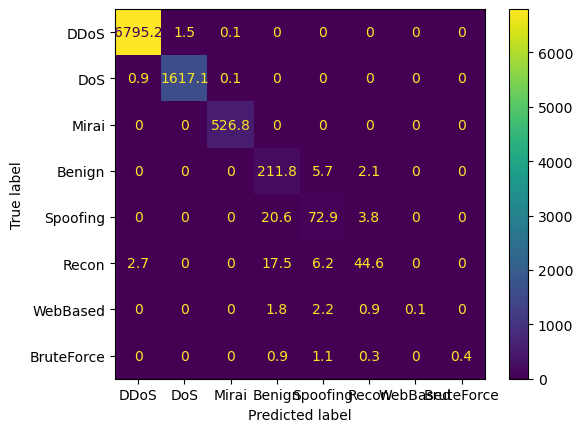

In [53]:
process_confusion_matrix(y_full_test, y_full_pred)

### Optimized

In [54]:
# redo preprocessing
best_preprocessor.fit(X_full_train)
X_full_train = pd.DataFrame(best_preprocessor.transform(X_full_train.copy()), columns=X_full_train.columns)
X_full_test = pd.DataFrame(best_preprocessor.transform(X_full_test.copy()), columns=X_full_test.columns)

# redo feature selection
X_full_train = X_full_train[best_selected_features]
X_full_test = X_full_test[best_selected_features]

# redo data balancing
X_full_train, y_full_train = fit_resample(
    X_full_train, y_full_train, best_over_threshold, best_under_threshold
)

# redo classifier building
model = build_classifier(best_model_params)

In [55]:
%%time
model.fit(X_full_train, y_full_train)
y_full_pred = model.predict(X_full_test)

CPU times: user 9h 27min 3s, sys: 2min 49s, total: 9h 29min 53s
Wall time: 17min 19s


In [56]:
process_metrics(y_full_test, y_full_pred)

OrderedDict([   ('Accuracy', 0.9963908258004763),
                ('Precision (Macro)', 0.9557069785172527),
                ('Precision (Micro)', 0.9963908258004763),
                ('Precision (Weighted)', 0.99642188074163),
                ('Recall (Macro)', 0.8449207102696562),
                ('Recall (Micro)', 0.9963908258004763),
                ('Recall (Weighted)', 0.9963908258004763),
                ('F1 (Macro)', 0.8858223314704144),
                ('F1 (Micro)', 0.9963908258004763),
                ('F1 (Weighted)', 0.9963031307111397)])


In [57]:
process_classification_report(y_full_test, y_full_pred)

              precision    recall  f1-score   support

        DDoS   0.999867  0.999901  0.999884   6796912
         DoS   0.999777  0.999428  0.999603   1618147
       Mirai   0.999962  0.999899  0.999931    526825
      Benign   0.913801  0.982886  0.947085    219639
    Spoofing   0.928685  0.863506  0.894910     97301
       Recon   0.916721  0.837928  0.875555     70913
    WebBased   0.977054  0.531615  0.688576      4966
  BruteForce   0.909789  0.544202  0.681034      2613

    accuracy                       0.996391   9337316
   macro avg   0.955707  0.844921  0.885822   9337316
weighted avg   0.996422  0.996391  0.996303   9337316



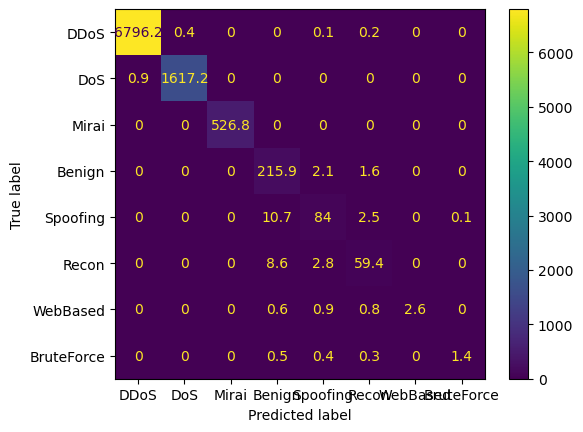

In [58]:
process_confusion_matrix(y_full_test, y_full_pred)